In [2]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

In [1]:
dic={'a': 1,
 'c': {'a': 2,
       'b': {'x': 5,
             'y' : 10}},
 'd': [1, 2, 3]}

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'1.2.2'

In [2]:
dic

{'a': 1, 'c': {'a': 2, 'b': {'x': 5, 'y': 10}}, 'd': [1, 2, 3]}

In [3]:
import pandas as pd

In [4]:
df = pd.io.json.json_normalize(dic,sep='')

In [8]:
df.to_dict(orient='records')[0]

{'a': 1, 'ca': 2, 'cbx': 5, 'cby': 10, 'd': [1, 2, 3]}

In [11]:
from pandas.io.json.normalize import nested_to_record    

nested_to_record(dic, sep='')

{'a': 1, 'd': [1, 2, 3], 'ca': 2, 'cbx': 5, 'cby': 10}

In [3]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [4]:
captions = open(token, 'r').read().strip().split('\n')

In [5]:
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

## Creating a dictionary containing all the captions of the images

In [6]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [7]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [8]:
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [9]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [10]:
img[:5]

['Flickr8k_Dataset/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [11]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [12]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [13]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [14]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [15]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [16]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [17]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [18]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

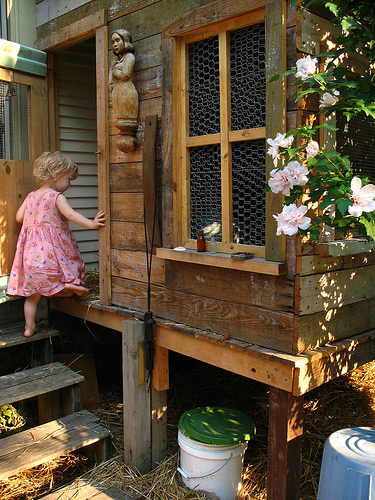

In [19]:
Image.open(train_img[0])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [20]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [21]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


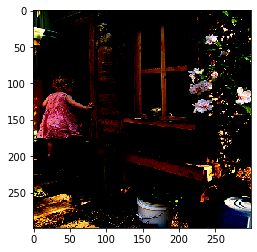

In [22]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [23]:
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [24]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [25]:
tryi = model_new.predict(preprocess(train_img[0]))

In [26]:
tryi.shape

(1, 2048)

In [27]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [28]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [26:19<00:00,  4.44it/s]


In [29]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [30]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [31]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [32]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:29<00:00,  3.73it/s]


In [33]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [34]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [35]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [36]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [37]:
len(train_d)

6000

In [39]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [40]:
len(val_d)

1000

In [41]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [42]:
len(test_d)

1000

Calculating the unique words in the vocabulary.

In [43]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [44]:
words = [i.split() for i in caps]

In [45]:
unique = []
for i in words:
    unique.extend(i)

In [46]:
unique = list(set(unique))

In [82]:
# with open("unique.p", "wb") as pickle_d:
#     pickle.dump(unique, pickle_d) 

In [47]:
unique = pickle.load(open('unique.p', 'rb'))

In [48]:
len(unique)

8256

Mapping the unique words to indices and vice-versa

In [49]:
word2idx = {val:index for index, val in enumerate(unique)}

In [50]:
word2idx['<start>']

5553

In [51]:
idx2word = {index:val for index, val in enumerate(unique)}

In [52]:
idx2word[5553]

'<start>'

Calculating the maximum length among all the captions

In [53]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [54]:
len(unique), max_len

(8256, 40)

In [55]:
vocab_size = len(unique)

In [56]:
vocab_size

8256

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [57]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [58]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [59]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [60]:
df.head()

image_id  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                            captions  
0  <start> A child in a pink dress is climbing up...  
1  <start> A girl going into a wooden building . ...  
2  <start> A little girl climbing into a wooden p...  
3  <start> A little girl climbing the stairs to h...  
4  <start> A little girl in a pink dress going in...

In [61]:
len(df)

30000

In [62]:
c = [i for i in df['captions']]
len(c)

30000

In [63]:
imgs = [i for i in df['image_id']]

In [64]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [65]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5553
Woman => 860
writing => 3643
on => 803
a => 32
pad => 6042
in => 8156
room => 7022
with => 4350
gold => 8122
, => 5672
decorated => 4539
walls => 7915
. => 7023
<end> => 5232


In [66]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [67]:
samples_per_epoch

383454

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [68]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [69]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [70]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [71]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Merging the models and creating a softmax classifier

In [72]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [73]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [74]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700                                       
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 300)       2476800                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 40, 256)       570368                                       
___________________________________________________________________________________________

In [75]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1


C:\Users\nirmal.silwal\AppData\Local\Continuum\anaconda3\envs\learningmate\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


7514s - loss: 4.3376 - acc: 0.3100


In [139]:
final_model.save_weights('trainedByNirmal.h5')

In [141]:
final_model.load_weights('trainedByNirmal.h5')

In [80]:
# final_model.optimizer.lr = 1e-4
# final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, verbose=2)

In [79]:
final_model.layers

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


In [ ]:
print('done training')

In [103]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
959s - loss: 3.3411 - acc: 0.4033


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [111]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
959s - loss: 3.3024 - acc: 0.4138


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [119]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
958s - loss: 3.2991 - acc: 0.4214


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [144]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
959s - loss: 3.2920 - acc: 0.4288


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [161]:
final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
958s - loss: 3.2612 - acc: 0.4302


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [174]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
958s - loss: 3.2604 - acc: 0.4357


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [175]:
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')

In [57]:
final_model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

In [58]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
1017s - loss: 3.2368 - acc: 0.4399


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [69]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
993s - loss: 3.2185 - acc: 0.4458


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [78]:
final_model.save_weights('time_inceptionV3_3.21_loss.h5')

In [79]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
993s - loss: 3.2044 - acc: 0.4505


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [88]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
992s - loss: 3.1809 - acc: 0.4539


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [101]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
992s - loss: 3.1510 - acc: 0.4589


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [110]:
final_model.save_weights('time_inceptionV3_3.15_loss.h5')

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1
992s - loss: 3.1449 - acc: 0.4643


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [54]:
final_model.load_weights('time_inceptionV3_1.5987_loss.h5')

## Predict funtion

In [81]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [82]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

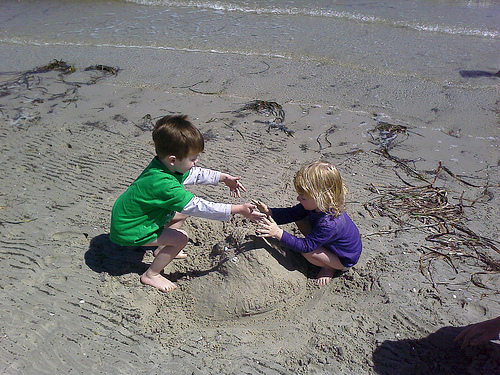

In [83]:
try_image = test_img[150]
Image.open(try_image)

In [84]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A girl in a red shirt is is is is is standing in the water .
Beam Search, k=3: A girl in a red shirt is in the water .
Beam Search, k=5: A girl in a red shirt is in the water .
Beam Search, k=7: A girl in a red shirt is in the water .


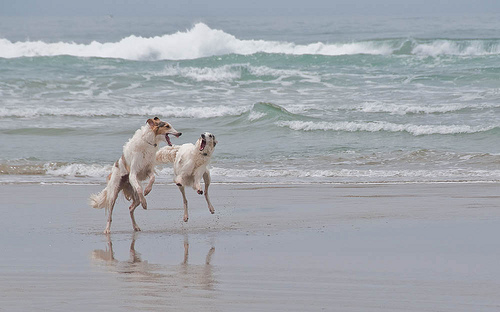

In [134]:
try_image = test_img[800]
Image.open(try_image)

In [135]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))
print ('Beam Search, k=9:', beam_search_predictions(try_image, beam_index=9))

Normal Max search: A dog is running in the water .
Beam Search, k=3: A black dog is running in the water .
Beam Search, k=5: A and white dog is running through the water .
Beam Search, k=7: A and white dog is running through the water .
Beam Search, k=9: A and white dog is running through the water .


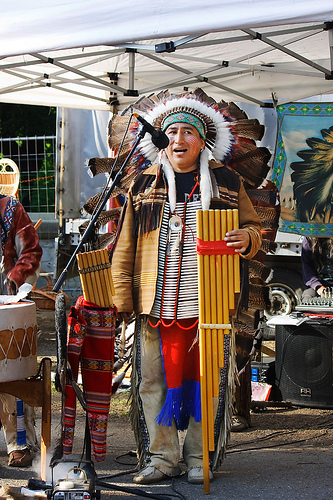

In [137]:
try_image = test_img[802]
Image.open(try_image)

In [138]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))
print ('Beam Search, k=9:', beam_search_predictions(try_image, beam_index=9))

Normal Max search: A man in a white shirt is standing on a white shirt .
Beam Search, k=3: A man in a white shirt and a white and white shirt and a white and white shirt is standing on a street .
Beam Search, k=5: A man in a a white shirt in a a white shirt is standing on a street .
Beam Search, k=7: A man in a a white shirt in a white shirt is standing on a street .
Beam Search, k=9: A man in a white shirt in a building .


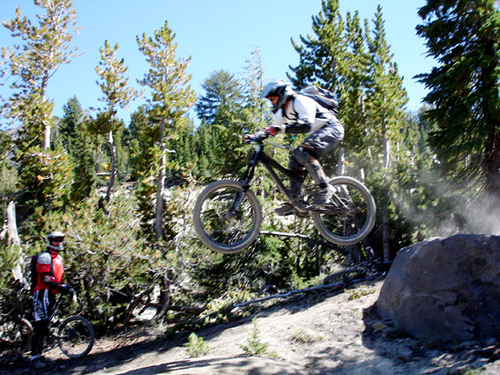

In [85]:
try_image2 = test_img[40]
Image.open(try_image2)

In [86]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A man in a red shirt is riding a bike .
Beam Search, k=3: A man in a red shirt is riding a bike .
Beam Search, k=5: A man in a bike is riding a bicycle .
Beam Search, k=7: A man in a red shirt is riding a bicycle .


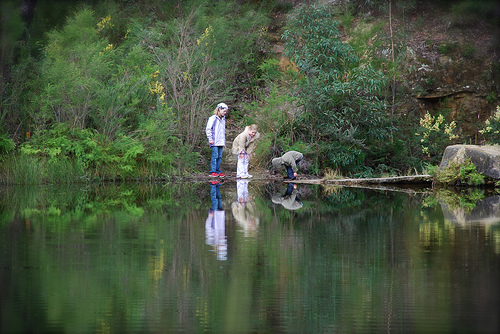

In [87]:
# try_image3 = test_img[159]
# Image.open(try_image3)
val1=val_img[23]
Image.open(val1)

Normal Max search: A man in a red shirt is riding a bike .
Beam Search, k=3: A man in a red shirt is riding a bike .
Beam Search, k=5: A man in a bike is riding a bicycle .
Beam Search, k=7: A man in a red shirt is riding a bicycle .


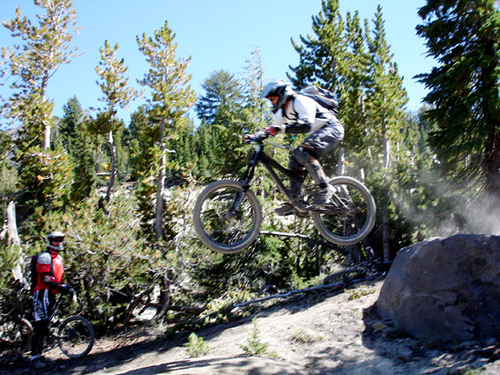

In [89]:
try_image4 = 'Flickr8k_Dataset/Flicker8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

Normal Max search: A brown dog is running on the grass .
Beam Search, k=3: A brown dog is running through the grass .
Beam Search, k=5: A brown dog is running through the grass .
Beam Search, k=7: A brown dog is running .


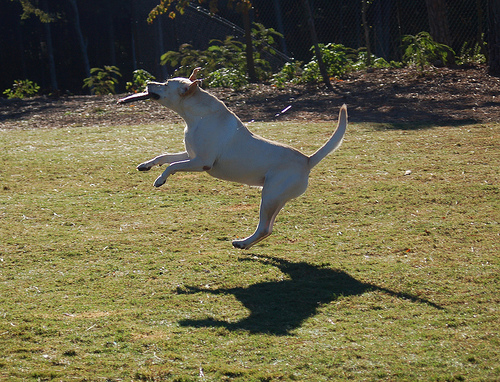

In [90]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A dog is running on the snow .
Beam Search, k=3: A brown dog is running on the snow .
Beam Search, k=5: A brown dog is running on the snow .
Beam Search, k=7: A brown dog is running on the snow .


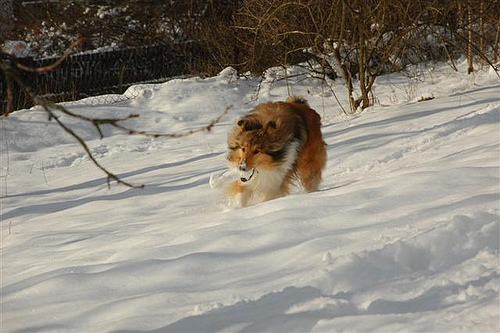

In [91]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/384577800_fc325af410.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man in a red shirt is standing in the water .
Beam Search, k=3: A man in a red shirt in a red shirt in the water .
Beam Search, k=5: A man in a red shirt is in the water .
Beam Search, k=7: A man in a red shirt is in the water .


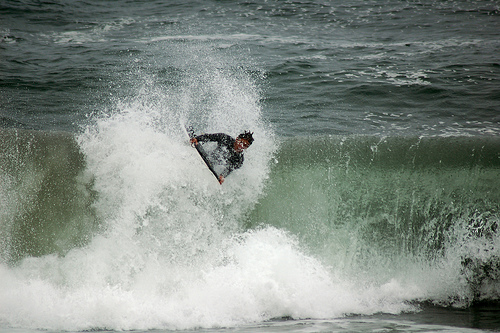

In [92]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3631986552_944ea208fc.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man in a red shirt is standing on a a white shirt .
Beam Search, k=3: A man in a red shirt is standing on the air .
Beam Search, k=5: A man in a red shirt is standing on the air .
Beam Search, k=7: A man in a red shirt is standing on the air .


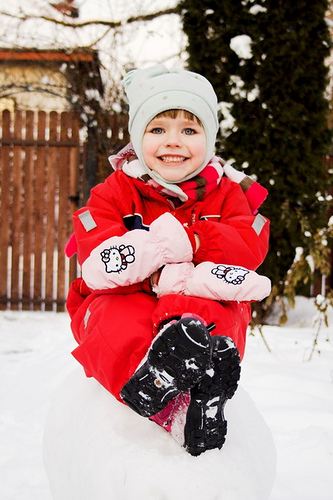

In [93]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3320032226_63390d74a6.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [133]:
test_img

['Flickr8k_Dataset/Flicker8k_Dataset\\1056338697_4f7d7ce270.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\106490881_5a2dd9b7bd.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1082379191_ec1e53f996.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1084040636_97d9633581.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1096395242_fc69f0ae5a.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1107246521_d16a476380.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1119015538_e8e796281e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1122944218_8eb3607403.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1131800850_89c7ffd477.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1131932671_c8d17751b3.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\113678030_87a6a6e42e.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\114051287_dd85625a04.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\115684808_cb01227802.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1167669558_87a8a467d6.jpg',
 'Flickr8k_Dataset/Flicker8k_Dataset\\1174525839_7c1e6cfa86.jpg',
 'Flickr8k_Dat

Normal Max search: A man in a red shirt is riding a bike .
Beam Search, k=3: A man in a red shirt is riding a bike .
Beam Search, k=5: A man in a red shirt is riding a bike .
Beam Search, k=7: A man in a red shirt is riding a bike .


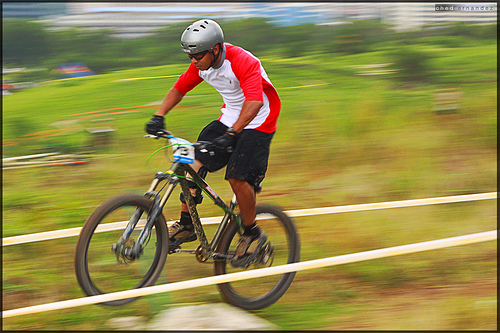

In [94]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/3316725440_9ccd9b5417.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man in a white shirt is standing on a snow .
Beam Search, k=3: A man in a red shirt is standing on the snow .
Beam Search, k=5: A man in a red shirt is standing on the snow .
Beam Search, k=7: A man in a white shirt is standing on the snow .


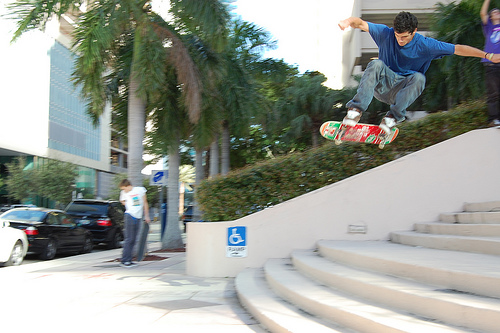

In [95]:
im = 'Flickr8k_Dataset/Flicker8k_Dataset/2306674172_dc07c7f847.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A girl in a red shirt is holding a a white shirt .
Beam Search, k=3: A girl in a red shirt is standing on a white shirt .
Beam Search, k=5: A girl in a red shirt is holding a white shirt .
Beam Search, k=7: A girl in a red shirt is holding a yellow shirt .


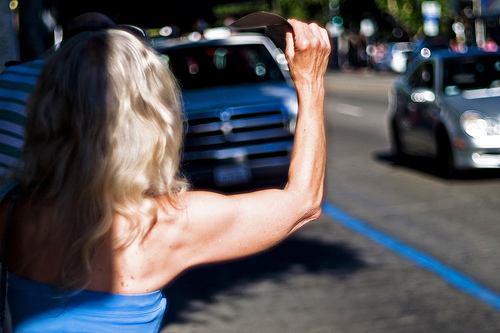

In [96]:
# example = "C:/Users/nirmal.silwal/Desktop/Nirmal/Python/notebook here/kerasimplementation/Image-Captioning/Flickr8k_Dataset/Flicker8k_Dataset/politician.jpg"
example = test_img[0]
print ('Normal Max search:', predict_captions(example))
print ('Beam Search, k=3:', beam_search_predictions(example, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(example, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(example, beam_index=7))
Image.open(example)

Normal Max search: A girl in a red shirt is holding a red shirt .
Beam Search, k=3: A young girl in a red shirt in a red shirt is holding a woman .
Beam Search, k=5: A young girl in a red shirt in a red shirt is holding a woman .
Beam Search, k=7: A young girl in a red shirt in a red shirt is holding a woman .


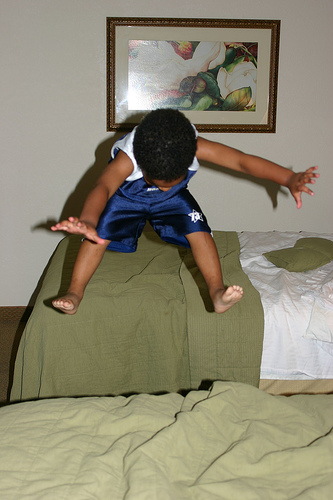

In [97]:
# im = 'Flickr8k_Dataset/Flicker8k_Dataset/2542662402_d781dd7f7c.jpg'
im = 'Flickr8k_Dataset/Flicker8k_Dataset/1131932671_c8d17751b3.jpg'

print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Flickr8k_Dataset/Flicker8k_Dataset\223299142_521aedf9e7.jpg
Normal Max search: A man in a red shirt is standing on the snow .
Beam Search, k=3: A man in a red shirt in a red shirt in the snow .
Beam Search, k=5: A man in a red shirt in a red shirt in the snow .
Beam Search, k=7: A man in a red shirt in a red shirt in the snow .


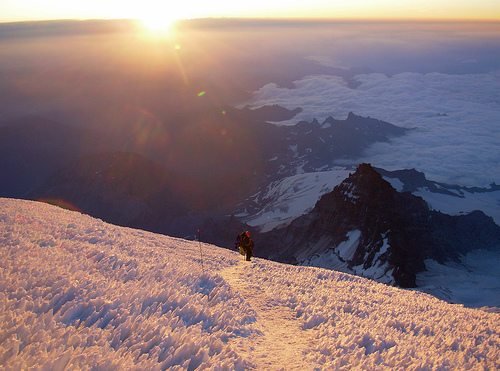

In [98]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)